# Classifying High-Energy Seismic Bumps using Machine Learning

### Step 1: Import and Clean the Data

#### 1.1 Import the .arff file and convert it into a dataframe

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import optimize
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [2]:
data = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data[0])
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [3]:
# fix broken string columns by decoding them to utf-8 
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.str.decode("utf-8"))

In [4]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
df["class"] = df["class"].astype(np.int64)

### Step 2: Feature Engineering, Data Cleaning and EDA

In [6]:
# Convert seismic intensity levels from categorical to numerical
# Note: we assign values in an increasing order so that it can represent rising intensity levels
def map_seismic_intensity(i):
    if i == 'a':
        return 0
    elif i == 'b':
        return 1
    elif i == 'c':
        return 2
    elif i == 'd':
        return 3
    
    
# Map the associated columns
df["seismic"] = df["seismic"].apply(lambda x: map_seismic_intensity(x))
df["seismoacoustic"] = df["seismoacoustic"].apply(lambda x: map_seismic_intensity(x))
df["ghazard"] = df["ghazard"].apply(lambda x: map_seismic_intensity(x))

# Convert the shift column to binary
df["shift"] = df["shift"].apply(lambda x: 1 if x == 'W' else 0)

df["class"] = np.where(df['class'] == 0, -1, 1)

# Fill NAs
df = df.fillna(0)

In [7]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,0,0,0,15180.0,48.0,-72.0,-72.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0,0,0,14720.0,33.0,-70.0,-79.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,-1
2,0,0,0,8050.0,30.0,-81.0,-78.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0,0,0,28820.0,171.0,-23.0,40.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,-1
4,0,0,0,12640.0,57.0,-63.0,-52.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


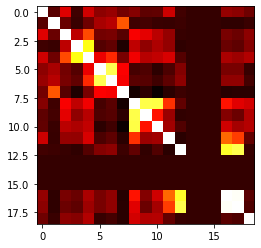

In [8]:
# Multivariate correlation analysis

plt.imshow(df.corr().fillna(0), cmap='hot', interpolation='nearest')
plt.show()


In [9]:
# A look at class distributions
df["class"].value_counts()

-1    2414
 1     170
Name: class, dtype: int64

In [10]:
neg_samples = df[df["class"] == -1].sample(n=170)
pos_samples = df[df["class"] == 1]

df = pd.concat([neg_samples, pos_samples])

In [11]:
df["class"].value_counts()

-1    170
 1    170
Name: class, dtype: int64

As evident, there aren't many rows for the positive label. This data is highly imbalanced and can skew the results of our model.

## Step 3: Normalizing the Data, Creating Train and Test sets

In [12]:
X = df.iloc[:, :18]
y = df.iloc[:, 18]


standard_scaler = preprocessing.StandardScaler()
X = standard_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Step 4: Creating and Testing Models

#### 4.1: Linear Support Vector Machine

In [13]:
class SupportVectorMachine:
    def __init__(self, X, y, max_iterations = 1000, lr = 1e-3, lmbda = 0.1, tolerance = 1e-5):
        self.X = np.array(X, dtype=np.float64)
        self.y = np.array(y, dtype=np.float64)
        self.max_iterations = max_iterations
        self.lr = lr
        self.lmbda = lmbda
        self.tolerance = tolerance
    
    def add_intercept(self):
        self.X = np.column_stack([np.ones([self.X.shape[0], 1]) , self.X])
        
    def cost(self, X, y, W):
        n = len(y)
        
        distances = np.dot(X, W)
        distances[distances < 0] = 0
        

        hinge_loss = self.lmbda * np.sum(distances)/n
        
        cost = 1/2*(np.linalg.norm(W)) + hinge_loss
        
        return cost
    
    def calculate_gradient(self, X, y, W):
        distance = 1 - (np.multiply(y, np.dot(X, W)))
        dw = np.zeros(len(W))

        for i, d in enumerate(distance):
            if max(0, d) == 0:
                di = W
            else:
                di = W - self.lmbda*y[i]*X[i]
            dw += di

        dw = dw/len(y)
        return dw

    def gradient_descent(self):
        self.error_sequences = []
        
        last = float('inf')
        
        
        for i in tqdm(range(self.max_iterations)):
            
            self.W = self.W - self.lr * self.calculate_gradient(self.X, self.y, self.W)
            

            cost = self.cost(self.X, self.y, self.W)
            diff = abs(cost - last)
            last = cost
            
            if i % 100 == 0:
                print("Epoch: {}    Cost: {}".format(i, cost))
            
            self.error_sequences.append(cost)
            
            
            if diff < self.tolerance:
                print("Model Stopped")
                break
            
    
    def predict(self, X, test = False):
        
        if test:
            X = np.column_stack([np.ones([X.shape[0], 1]) , X])
        
        y_pred = np.sign(np.dot(X, self.W))
        
        return y_pred

    
    def run(self):
        
        self.add_intercept()
        
        np.random.seed(15)
        self.W = np.random.randn(self.X.shape[1])
        
        self.gradient_descent()
        
        print("Training Complete!")
        
        plt.plot(self.error_sequences)

  3%|█▎                                   | 524/15000 [00:00<00:05, 2637.18it/s]

Epoch: 0    Cost: 1.7521067557938421
Epoch: 100    Cost: 1.5830838315370859
Epoch: 200    Cost: 1.4301740380809131
Epoch: 300    Cost: 1.2918947004252177
Epoch: 400    Cost: 1.1668592136032385
Epoch: 500    Cost: 1.0537760863719197


  7%|██▌                                 | 1065/15000 [00:00<00:05, 2624.71it/s]

Epoch: 600    Cost: 0.9514962172976619
Epoch: 700    Cost: 0.8590209295027109
Epoch: 800    Cost: 0.7754000651723201
Epoch: 900    Cost: 0.6998284084600552
Epoch: 1000    Cost: 0.631564444905563
Epoch: 1100    Cost: 0.569933244153887
Epoch: 1200    Cost: 0.5142923308112848
Epoch: 1300    Cost: 0.4640417087807399


 14%|█████                               | 2105/15000 [00:00<00:05, 2554.26it/s]

Epoch: 1400    Cost: 0.41865624311655203
Epoch: 1500    Cost: 0.37766610861865896
Epoch: 1600    Cost: 0.34063814889870375
Epoch: 1700    Cost: 0.30727157263073795
Epoch: 1800    Cost: 0.2771907546104453
Epoch: 1900    Cost: 0.2500893879259749
Epoch: 2000    Cost: 0.22581016295182427
Epoch: 2100    Cost: 0.20417249107325394


 17%|██████▎                             | 2611/15000 [00:01<00:04, 2482.64it/s]

Epoch: 2200    Cost: 0.1847344419101978
Epoch: 2300    Cost: 0.16727007030622643
Epoch: 2400    Cost: 0.15161773766170372
Epoch: 2500    Cost: 0.13770941435977369
Epoch: 2600    Cost: 0.1253519061834136
Epoch: 2700    Cost: 0.1143405615137634
Epoch: 2800    Cost: 0.1045897347067658

 21%|███████▍                            | 3105/15000 [00:01<00:04, 2438.53it/s]


Epoch: 2900    Cost: 0.09598942360229348
Epoch: 3000    Cost: 0.08849938874384888
Epoch: 3100    Cost: 0.08200063341365015
Epoch: 3200    Cost: 0.07634499833978177
Epoch: 3300    Cost: 0.07145852108653965


 26%|█████████▏                          | 3839/15000 [00:01<00:04, 2408.80it/s]

Epoch: 3400    Cost: 0.06726332813200309
Epoch: 3500    Cost: 0.06368408984051897
Epoch: 3600    Cost: 0.06066443722460537
Epoch: 3700    Cost: 0.05812866089733188
Epoch: 3800    Cost: 0.0560191963188524
Epoch: 3900    Cost: 0.054286967890747176


 27%|█████████▊                          | 4108/15000 [00:01<00:04, 2488.06it/s]


Epoch: 4000    Cost: 0.05287344246334168
Epoch: 4100    Cost: 0.05173364265153951
Model Stopped
Training Complete!


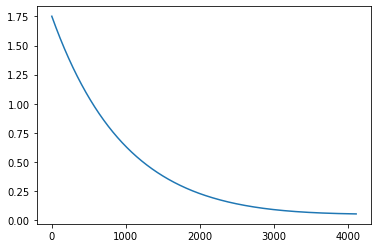

In [14]:
svm = SupportVectorMachine(X_train, y_train, max_iterations = 15000)
svm.run()

In [15]:
predict = svm.predict(X_test, test = True) # check performance
print('ROCAUC score:',roc_auc_score(y_test, predict))
print('Accuracy score:',accuracy_score(y_test, predict))
print('F1 score:',f1_score(y_test, predict, pos_label=1))

ROCAUC score: 0.6562500000000001
Accuracy score: 0.6666666666666666
F1 score: 0.575


#### 4.2: Using a Non-Linear SVM by using a RBF Kernel

In [16]:
class NonLinearSVM:
    def __init__(self, X, y, C):
        self.X = np.array(X)
        self.y = np.array(y)
        self.n_samples = len(X)
        self.C = C
        self.beta = None
        self.w = None
        self.supportVectors = None
        
    def rbf(self, x, y):
        """
            Radial Basis Function Kernel
        """
        diff = x - y
        return np.exp(-np.dot(diff, diff) * len(x)/2)
    
    
    def run(self):
        """
            Runs Quadratic Optimization to solve the Dual Lagrangian Form of a Soft Margin SVM
        """
        X = self.X
        y = self.y
        n_samples = self.n_samples
        

        XX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.rbf(x1, x2), 1, X), 1, X) 
        Xy = X * y[:, np.newaxis]
        yp = y.reshape(-1,1)

        
        GramXy = XX * np.matmul(yp, yp.T)
        
        print("Gram Matrix: ", GramXy.shape)
        
        def Ld0(G, beta):
            return beta.sum() - 0.5 * beta.dot(beta.dot(G))

        def partialDerivation(G, beta):
            return np.ones_like(beta) - beta.dot(G)
        
        # Constraints on beta
        # equality ==> y.dot(beta) = 0
        # inequalities ==> 2N constraints
        # first half for beta <= C and -beta <= 0
        
        # Initialize lagrangian multipliers betas
        beta = np.ones(n_samples).reshape(1,-1) 
        
        # We need to add the following constraints:
        # 1. Equality Constraint: Sigma(beta_i * y_i) = 0 (i.e summation of betas with the 
        # target y should be equal to zero)
        # 2. Inequality Constraint: 0 < bi < C
        B = np.concatenate((np.zeros(n_samples), self.C * np.ones(n_samples)))
        A = np.vstack((-np.eye(n_samples),np.eye(n_samples)))
        
        constraints = ({'type': 'eq','fun': lambda beta_i : np.dot(beta_i, y), 'jac': lambda beta_i: y},
                      
                      {'type': 'ineq', 'fun': lambda beta_i : B - np.dot(A, beta_i), 'jac' : lambda a: -A})
        
        
        print("Optimizing......")

        optres = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                   x0 = beta,
                                   method = 'SLSQP',
                                   jac = lambda a: -partialDerivation(GramXy,a),
                                   constraints = constraints)
        
        print("Solved!")
        
        self.beta = optres.x
        self.w = np.sum((self.beta[:,np.newaxis] * Xy),axis = 0)
        epsilon = 1e-6
        
        self.supportVectors = X[self.beta > epsilon]
        
        supportVectorsDistance = np.matmul(self.supportVectors, self.w)
        
        minDistance = np.argmin(supportVectorsDistance)
        
        supportLabels = y[self.beta > epsilon]
        self.intercept = supportLabels[minDistance] - supportVectorsDistance[minDistance]
        self.supportbetaY = supportLabels * self.beta[self.beta > epsilon]
     
    def predict(self, X):
        """
            Predict labels for a given X
        """
        def _predict(x):
            x1 = np.apply_along_axis(lambda s: self.rbf(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportbetaY[:, np.newaxis]
            return np.sum(x2)

        d = np.apply_along_axis(_predict, 1, X)
        return 2 * (d > 0) - 1   

In [17]:
clf = NonLinearSVM(X_train, y_train, C = 0.01)
clf.run()

Gram Matrix:  (238, 238)
Optimizing......
Solved!


In [18]:
y_pred = clf.predict(X_test)

# check performance
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred, pos_label=1))

ROCAUC score: 0.5162037037037037
Accuracy score: 0.5196078431372549
F1 score: 0.4731182795698925


In [19]:
import matplotlib.colors as pltcolors
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 17
N = 1000

def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,11], X[:,16], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,4], support[:,16], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

Number of support vectors = 238


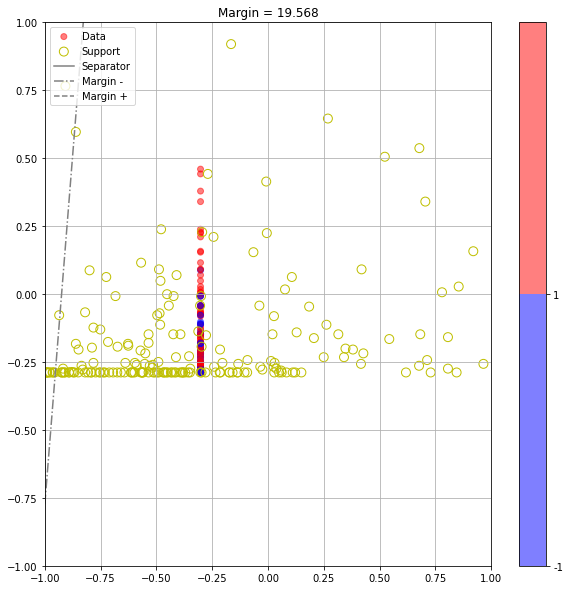

In [20]:
fig , ax = plt.subplots(1, figsize = (10,10))
plotSvm(np.array(X_train),np.array(y_train), support= np.array(clf.supportVectors), w = clf.w, intercept = clf.intercept,ax=ax)